In [1]:
# Ctrl + / to comment out section

In [2]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

In [3]:
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 20})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [4]:
import fsps
import sedpy
import prospect

In [5]:
vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

numpy: 2.2.5
scipy: 1.15.3
h5py: 3.12.1
fsps: 0.4.7
prospect: 1.4.0


In [6]:
import emcee
import dynesty

# Setup

*Prospector* requires several ingredients to conduct a fit.  These are:
  1. An `obs` dictionary (with the data we intend to fit)
  2. A stellar population synthesis object (a *source*) to predict spectra from parameters
  3. A `model` object (to describe, store, and translate parameters and priors)
  4. A likelihood or posterior probability function
  
It can also useful to collect the meta-parameters controlling how these ingredients are created and how the fit is conducted in a ``run_params`` dictionary. We will do that as we go along.  We will also encapsulate each step of the setup in a series of `build_x()` functions.

## The data to be fit: `build_obs()`

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.  It is also passed to the likelihood functions for calculating the likelihood of the data for a given model.

**Units:** The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.  Also note that mask values should be `True` for data that you want to fit, and `False` for data that is to be ignored in the likelihood calculation.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
We will do this through a `build_obs` method, that takes some meta-parameters.
In this example we use photometry from a row in Table 2 of Johnson et al. 2013

In [7]:
def build_obs(snr=10, ldist=10.0, **extras_):
    """Build a dictionary of observational data. In this example,
    the data consist of photometry for a single nerby dwarf galaxy
    from Johnson et al. 2013.
    
    :param snr:
        The S/N to assign to the photometry, since none are reported
        in Johnson et al. 2013.
        
    :param ldist:
        The luminosity distance to assume for translating absolute
        magnitudes into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy
    
    # The obs dictionary, empty for now
    obs = {}
    
    # These are the names of the relevant filters
    # in the same order as the photometric data (see below)
    galex = ['galex_FUV', 'galex_NUV']
    spitzer = ['spitzer_irac_ch'+n for n in ['1','2','3','4']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i','z']]
    filternames = galex + sdss + spitzer
    # And here we instantiate the 'Filter()' objects using methods in 'sedpy',
    # and put the resultinf list of Filter objects in the 'filters' key of the 'obs' dictionary
    obs['filters'] = sedpy.observate.load_filters(filternames)
    
    # Now we store the measured fluxes for a single object, **in the same order as 'filters'**
    # In this example we use a row of absoute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied 'ldist' meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    M_AB = np.array([-11.93, -12.37, -13.37, -14.22, -14.61, -14.86,
                     -14.94, -14.09, -13.62, -13.23, -12.78])
    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm
    obs['maggies'] = 10**(-0.4*mags)
    
    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied 'snr' meta-parameter.
    obs['maggies_unc'] = (1./snr) * obs['maggies']
    
    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit,
    # and *False* for values you want to ignore. Here we ignore the spitzer bands.
    obs['phot_mask'] = np.array(['spitzer' not in f.name for f in obs['filters']])
    
    # This is an array of effective wavelengths for each of the filters.
    # It is not necessary, but it can be useful for plotting, so we store it here as a convenience
    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])
    
    # We do not have a spectrum, so we set some required elements of hte obs dictionary to None.
    # (This would be a vector of vacuum wavelengths in angstroms)
    obs['wavelength'] = None
    # (This would be the spectrum in units of maggies)
    obs['spectrum'] = None
    # (Spectral uncertainties are given here)
    obs['unc'] = None
    # (Again, to ignore a particular wavelength, set the value of the
    # corresponding element of the mask to *False*)
    obs['mask'] = None
    
    # This function ensures all requried keys are present in the obs dicitonary,
    # adding default values if necessary.
    obs = fix_obs(obs)
    
    return obs

In [8]:
run_params = {}
run_params['snr'] = 10.0
run_params['ldist'] = 10.0

In [9]:
# Build the obs dictionary using the meta-parameters
obs = build_obs(**run_params)

In [10]:
# Look at the contents of the obs dictionary
print('Obs Dictionary Keys:\n\n{}\n'.format(obs.keys()))
print('--------\nFilter objects:\n')
print(obs['filters'])

Obs Dictionary Keys:

dict_keys(['filters', 'maggies', 'maggies_unc', 'phot_mask', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'mask', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(spitzer_irac_ch1), <class 'sedpy.observate.Filter'>(spitzer_irac_ch2), <class 'sedpy.observate.Filter'>(spitzer_irac_ch3), <class 'sedpy.observate.Filter'>(spitzer_irac_ch4)]


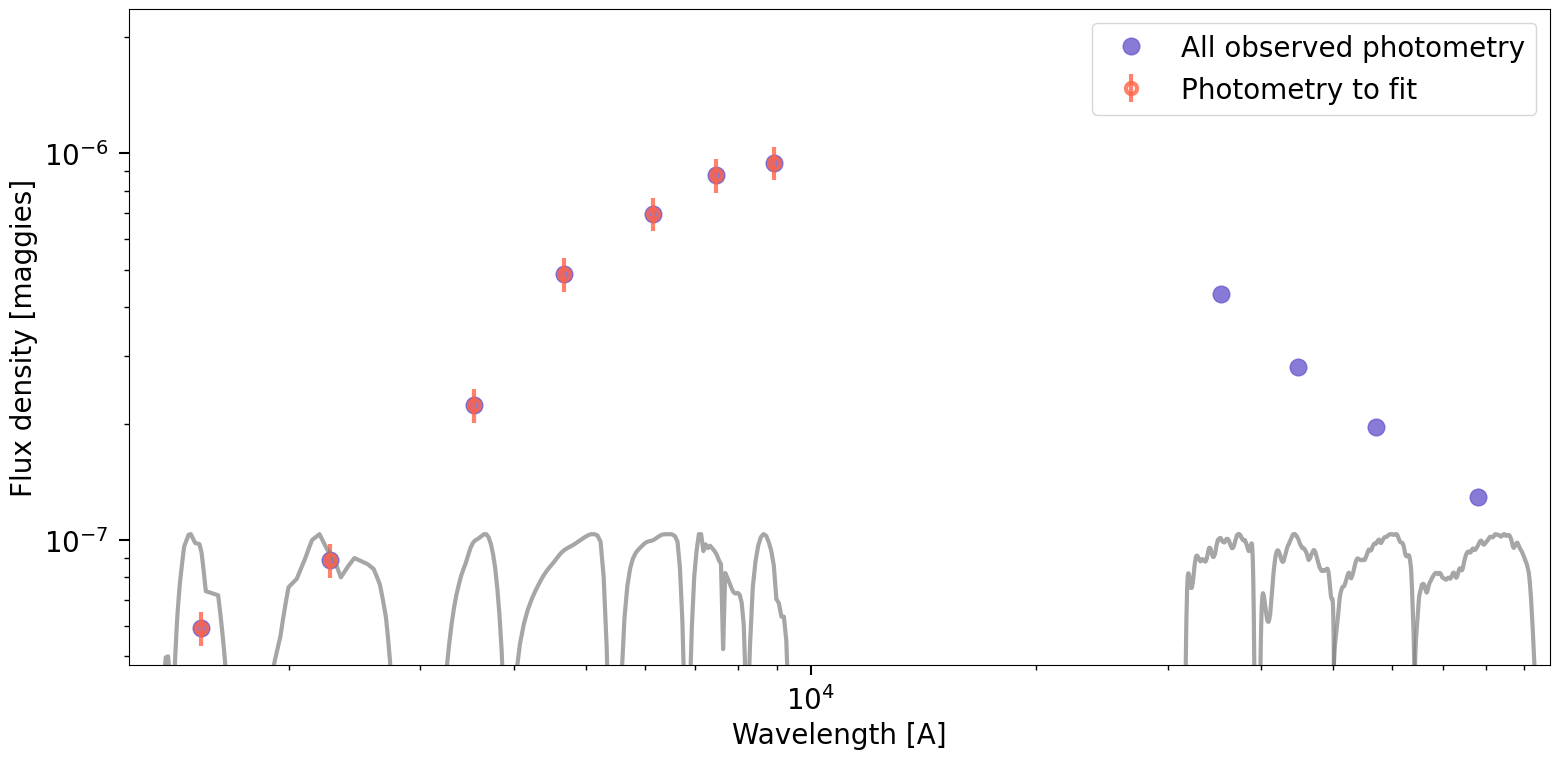

In [11]:
# --- Plot the Data ---
# This is why we stored these...
wphot = obs['phot_wave']

# Establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs['maggies'].min()*0.8, obs['maggies'].max()/0.4
figure(figsize=(16,8))

# Plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# Overplot only the data we intend to fit
mask = obs['phot_mask']
errorbar(wphot[mask], obs['maggies'][mask],
         yerr=obs['maggies_unc'][mask],
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato',
         markeredgewidth=3)

# Plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# Prettify
xlabel('Wavelength [A]')
ylabel('Flux density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale('log')
yscale('log')
legend(loc='best', fontsize=20)
tight_layout()

show()


## The model object: `build_model()`

Now we need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the MCMC samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the sps objects' `get_spectrum()` method.

To create the model object we need a list or dictionary of model parameters and some infomation about them.  Each parameter must a have a `name`, a length `N` (vector parameters are possible), an initial value `init`, and must be specified as either a free parameter or a fixed parameter via an `isfree` key.  If it is a free parameter it *must* have a prior specified as well, which we will get from the `priors` module.  Please see the documentation for that module for details on the available priors.

Let's start by creating a dictionary that describes a single parameter controlling the stellar mass.

In [12]:
from prospect.models import priors
mass_param = {'name':'mass',
              # The mass parameter here is a scalar, so it has N=1
              'N': 1,
              # We will be fitting for the mass, so it is a free parameter
              'isfree': True,
              # This is the initial value. For fixed parameters,
              # this is the value that will always be used.
              'init': 1e8,
              # This sets the prior probability for the parameter
              'prior': priors.LogUniform(mini=1e6, maxi=1e12),
              # This sets the initial dispersion to use when generating
              # clouds of emcee 'walkers'. It is not required, but can be very helpful.
              'init_disp': 1e6,
              # This sets the minimum dispersion to use when generating
              # clouds of emcee 'walkers'. It is not required, but can be useful if burn-in
              # rounds leave the walker distribution too narrow for some reason.
              'disp_floor': 1e6,
              # This is not required, but can be helpful
              'units': 'solar masses formed',
             }

In [13]:
mass_param

{'name': 'mass',
 'N': 1,
 'isfree': True,
 'init': 100000000.0,
 'prior': <class 'prospect.models.priors.LogUniform'>(mini=1000000.0,maxi=1000000000000.0),
 'init_disp': 1000000.0,
 'disp_floor': 1000000.0,
 'units': 'solar masses formed'}

Ok, that's the description for one parameter.  Let's **build up the rest of our model** as a dictionary of these parameter descriptions, keyed by parameter name.  The type of model you build will depend on your data, the type of object you are looking at,  and your scientific question. For this data, at a minimum we will need some sort of distance or redshift information (which in this example is a fixed parameter), and something descibing the SFH.  We could also add parameters controlling metallicity, dust attenuation and emission, nebular emission, even the IMF. Note that any parameter whose value is not explicitly specified via a model parameter dictionary will be given the default value from python-FSPS.

While we could keep adding parameters by hand, the easiest way to build up this model is to start with some predefined parameter sets from the `prospect.models.templates` module, and then modify them to suit our needs. First, lets look at what pre-packaged parameter sets are available.

In [14]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'agn_eline':
  Add AGN emission lines
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set

It looks like the `"parametric_sfh"` parameter set will do most of what we want. Let's look at it in more detail.

In [15]:
TemplateLibrary.describe("parametric_sfh")

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 


That looks pretty good, this model has 5 free parameters:
- stellar mass *formed* $M_\star$,
- metallicity log $Z/Z_\odot$,
- age $t$ of the galaxy
- star formation timescale $\tau$ for an exponenetially declining star formation history (SFH), and
- dust attenuation optical depth for a foreground screen, $A_V$.

Everything else here is fixed explicity (e.g. Chabrier IMF via `imf_type:2`). There are many other `sps` parameters that are set implicitly in the FSPS defaults. See the python-FSPS documentation for a complete list and details on the default values.

Note that by default the stellar mass here refers to the stellar mass *formed* by the given age, which will always be slightly higher than the *surviving* stellar mass, due to mass loss during stellar evolution (winds, SNe, etc.)

To tailor this model to our data we'll want to just adjust a couple of the initial values and priors, and add a parameter that will set the distance even through the redshift of these objects is zero (remember we used absolute magnitudes - these particular very nearby objects are decoupled form the Hubble flow and have very small reshifts, or even blueshifts).

However, as for the `obs` dictionary we will do all this model building inside a method called `build_model`. This is useful because then we can control (at run-time) how the model is built via more meta-parameters. For example, the redshift of the model can be specified, or we can decide to change a prior depending on which object the model is fitting. Let's do an example where we change whether the metallicity is a free parameter of the fit or fixed to a partiuclar value, optionally turn on dust emission in the mdoel, and where we can set the reshift by hand as well.

In [16]:
def build_model(object_redshift=None, ldist=10.0, fixed_metallicity=None, add_duste=False, **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model. Spectra and observed
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity  (:math: `log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel    
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    
    # Get (a copy of) one of the prepackaged model set dicitonaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by a parameter name.
    model_params = TemplateLibrary['parametric_sfh']
    
    # Now add the lumdist parameter by hand as another entry in the dictionary.
    # This will control the distance since we are setting the redshift to zero.
    # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes,
    # so we use that here too, since the `maggies` are appropriate for that distance.
    model_params['lumdist'] = {'N': 1, 'isfree': False, 'init': ldist, 'units': 'Mpc'}
    
    # Let's make some changes to the initial values appropriate for our objects and data
    model_params['zred']['init'] = 0.0
    model_params['dust2']['init'] = 0.05
    model_params['logzsol']['init'] = -0.5
    model_params['tage']['init'] = 13.
    model_params['mass']['init'] = 1e8
    
    # These are dwarf galaxies, so let's also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward.
    model_params['dust2']['prior'] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params['tau']['prior'] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params['mass']['prior'] = priors.LogUniform(mini=1e6, maxi=1e10)
    
    # If we are going to be using emcee, it is useful to provide a
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params['mass']['disp_floor'] = 1e6
    model_params['tau']['disp_floor'] = 1.0
    model_params['tage']['disp_floor'] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # Make it a fixed parameter
        model_params['logzsol']['isfree'] = False
        # And use the value supplied by the fixed_metallicity keyword
        model_params['logzsol']['init'] = fixed_metallicity
        
    if object_redshift is not None:
        # Make sure zred is fixed
        model_params['zred']['isfree'] = False
        # And use the value supplied by the object_redshift keyword
        model_params['zred']['init'] = object_redshift
        
    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications,
        # and `TemplateLibrary` returns dictionaries of parameter specifications,
        # we can just update `model_params` with the parameters described in the
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary['dust_emission'])
        
    # Now instantiate the model object using this dictionary of parameter specifications.
    model = SedModel(model_params)
    
    return model

In [17]:
run_params['object_redshift'] = 0.0
run_params['fixed_metallicity'] = None
run_params['add_duste'] = True

Now let's build the model using the function and take a look at it:

In [18]:
run_params

{'snr': 10.0,
 'ldist': 10.0,
 'object_redshift': 0.0,
 'fixed_metallicity': None,
 'add_duste': True}

In [19]:
model = build_model(**run_params)
print(model)
print('\n---------------------------------------------------------------------------------------------------------')
print('\nInitial free parameter vector theta:\n  {}\n'.format(model.theta))
print('Initial parameter dictionary:\n{}'.format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1000000.0,maxi=10000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=100.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  lumdist: [10.] 
  add_dust_emission: [ True] 
  duste_umin: [1.] 
  duste_qpah: [4.] 
  duste_gamma: [0.001] 

---------------------------------------------------------------------------------------------------------

Initial free parameter vector theta:
  [ 1.0e+08 -5.0e-01  5.0e-02  1.3e+01  1.0e+00]

Initial parameter dictionary:
{'zred': array([0.]), 'mass': array([1.e+08]), 'logzsol': array([-0.5]), 'dus

# The source object: `build_sps()`

We are almost there, but we need an object that will build SEDs for a given set of parameters. In *prospector* we call these *sps* objects. Given a dictionary of parameters (provided by the model object), they must be able to return a spectrum and photometry -- corresponding to the data in the `obs` dictionary -- and maybe some ancillary information. The generation of spectra and photometry is often done using large spectral libraries and, for galaxies, isochrone information. Typically in *prospector* we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations, as described in the FSPS manual with `sfh_type`of 1, 4, or 5. Other `sps` objects can be used for non-parametric SFH, notably `prospect.sources.FastStepBasis`.

Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling how the object is instantiated.

In [20]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous:
        A value of 1 ensures that we use interpolation between SSPs to
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params['zcontinuous'] = 1

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones. It has one very important method, `get_spectrum()`. Indeed, the only definition of an `sps` object (for example if you want to make your own) is that it have this method. In typical use, any FSPS parameter can be passed to this method as an extra keyword argument and the model will be built using that parameter. Several additional parameters controlling, e.g., spectral smoothing or the wavelength calibration can also be passed to the default objects.

In [21]:
sps = build_sps(**run_params)
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.

    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        ``sps.wavelength``.

    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.

    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated.

    :param params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.

    :returns spec:
        Observed frame spectrum in AB maggies, unless ``peraa=True`` in which
        case the units are erg/s/cm^2/AA.

    :returns phot:
        Observed frame photometry in AB maggies.

    :returns mass_frac:
        The ratio o

# View the model

Now that we have the `sps` object we can also generate a prediction for the data from any set of model parameters. To see how this works, let's make an SED and plot it! This will use the initial parameter values for the model we built before.

Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently store in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF).

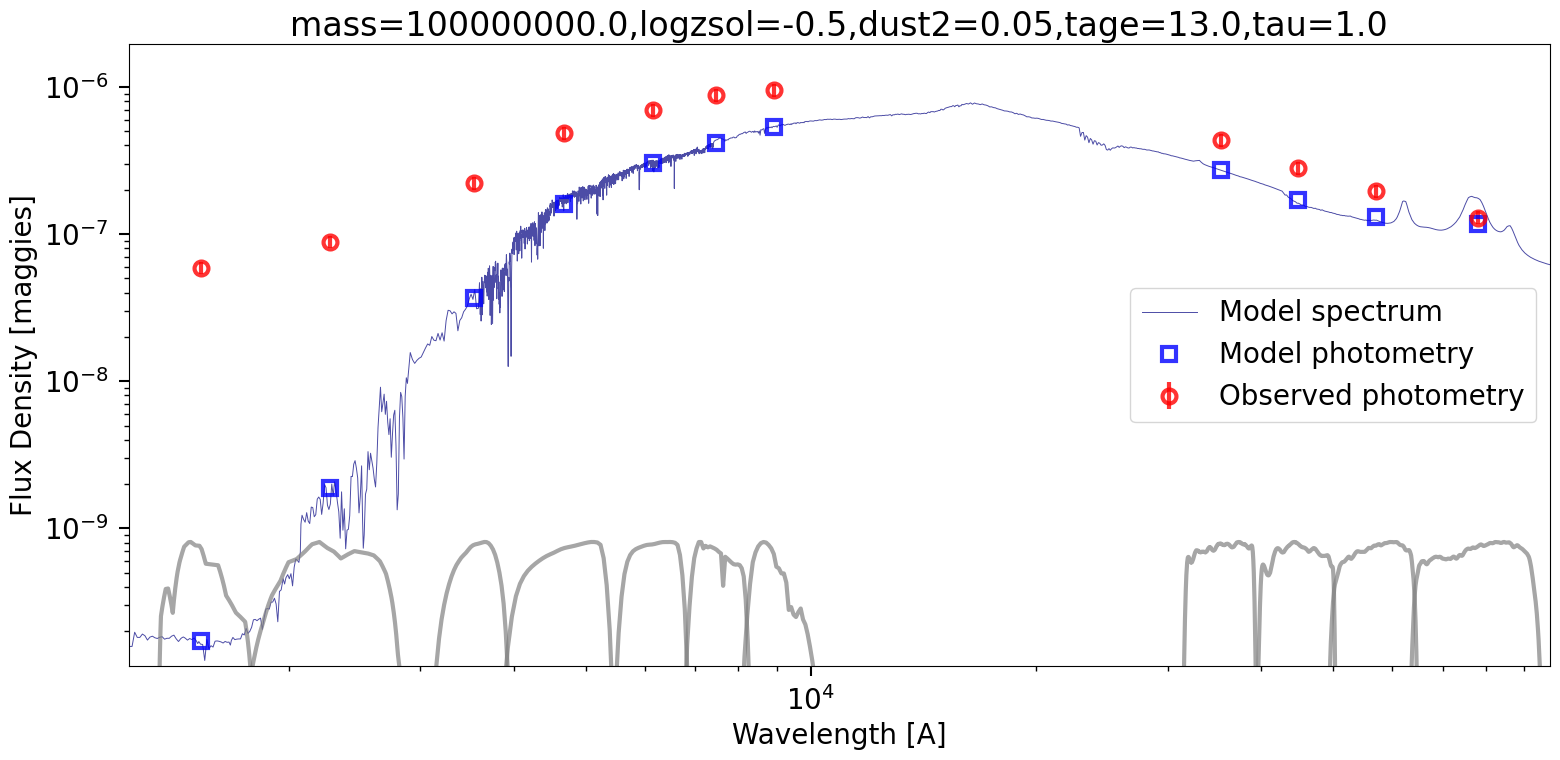

In [22]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0])
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # Cosmological redshifting
# Photometric effective wavelengths
wphot = obs['phot_wave']
# Spectroscopic wavelengths
if obs['wavelength'] is None:
    # *restframe* spectral wavelengths, since obs['wavelength'] is None
    wspec = sps.wavelengths
    wspec *= a # redshift them
else:
    wspec = obs['wavelength']
    
# Establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# Plot model + data
loglog(wspec, initial_spec, label='Model spectrum',
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue',
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', marker='o',
         markersize=10, alpha=0.8, ls='', lw=3, ecolor='red',
         markerfacecolor='none', markeredgecolor='red',
         markeredgewidth=3)
title(title_text)

# Plot filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

show()